<a href="https://www.kaggle.com/code/carolinariddick/passing-networks-with-statsbomb-futbol-analysis?scriptVersionId=274289337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Passing networks with statsbomb / Redes de pases con Statsbomb
### Africa Cup - final match.

#### We’ll use it to create a passing network and analyse how the players of a team are connected.

In [1]:
!pip install statsbomb --quiet
!pip install mplsoccer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import statsbomb as sb
from mplsoccer import Pitch, Sbopen
import matplotlib.pyplot as plt

### We’ll use the sbopen command, which allows us to directly load the event data.

In [3]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3923881) # Africa Cup - final match.

In [4]:
df['timestamp']

0              00:00:00
1              00:00:00
2              00:00:00
3              00:00:00
4       00:00:00.663000
             ...       
2694    00:51:53.947000
2695    00:51:53.947000
2696    00:52:07.776000
2697    00:52:09.411000
2698    00:52:09.411000
Name: timestamp, Length: 2699, dtype: object

### With the following data, we prepare and clean the file so that it can be presented exactly as we want.

### Remember to replace where it currently says ‘Cote d’Ivoire’ with the name of the team you’re analysing — but always make sure to match the name as it appears in the StatsBomb data, including any accents or special characters.

In [5]:
# We delete the suptitle
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Côte d'Ivoire"].iloc[0]["index"]

mask_cdm = (df.type_name == 'Pass') & (df.team_name == "Côte d'Ivoire") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")

# We add a new column to create the passing network
df_pass = df.loc[mask_cdm, ['x', 'y', 'end_x', 'end_y', 'player_name', 'pass_recipient_name']]

# We will show only the players surname
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])


In [6]:
df_pass

,x,y,end_x,end_y,player_name,pass_recipient_name
17,10.4,36.1,19.5,20.1,Fofana,Ndicka
20,20.1,16.7,28.8,1.7,Ndicka,Konan
23,32.4,2.8,20.8,7.1,Konan,Ndicka
26,20.6,6.9,16.7,42.5,Ndicka,Kossonou
29,28.9,48.8,33.1,21.2,Kossonou,Ndicka
...,...,...,...,...,...,...
1934,104.7,4.8,97.4,4.3,Adingra,Konan
1937,97.4,4.3,84.7,16.4,Konan,Seri
1940,83.2,17.7,97.2,75.2,Seri,Aurier
2004,50.4,71.8,62.4,66.5,Gradel,Kessié


### Final necessary steps: make sure that the locations are correct, and that the circles representing the players are sized appropriately according to how many passes they make or receive.

In [7]:
scatter_df = pd.DataFrame()

for i, name in enumerate(df_pass["player_name"].unique()):
    pass_x = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    rec_x = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    pass_y = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    rec_y = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    # We make sure that each player’s location corresponds to their average position for passes made and received.
    scatter_df.at[i, "x"] = np.mean(np.concatenate([pass_x, rec_x]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([pass_y, rec_y]))
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# We fit the size circle to show when the player makes more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)


In [8]:
scatter_df['marker_size']

0     960.0
1    1230.0
2    1500.0
3    1110.0
4     630.0
5    1500.0
6     810.0
7     690.0
8     390.0
9     210.0
Name: marker_size, dtype: float64

### The following commands are needed to complete the network:

In [9]:
# Count the passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: " ".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x': 'pass_count'}, axis='columns', inplace=True)

lines_df = lines_df[lines_df['pass_count'] > 2]

### We then design the passing network plot.

### 1. In line_color, you can choose the colour of the pitch borders and the title.
### 2. In color and edgecolors, you can set the fill and border colours of the circles representing the players.

### 3. In suptitle, you can add the title you want to give to the visualisation.

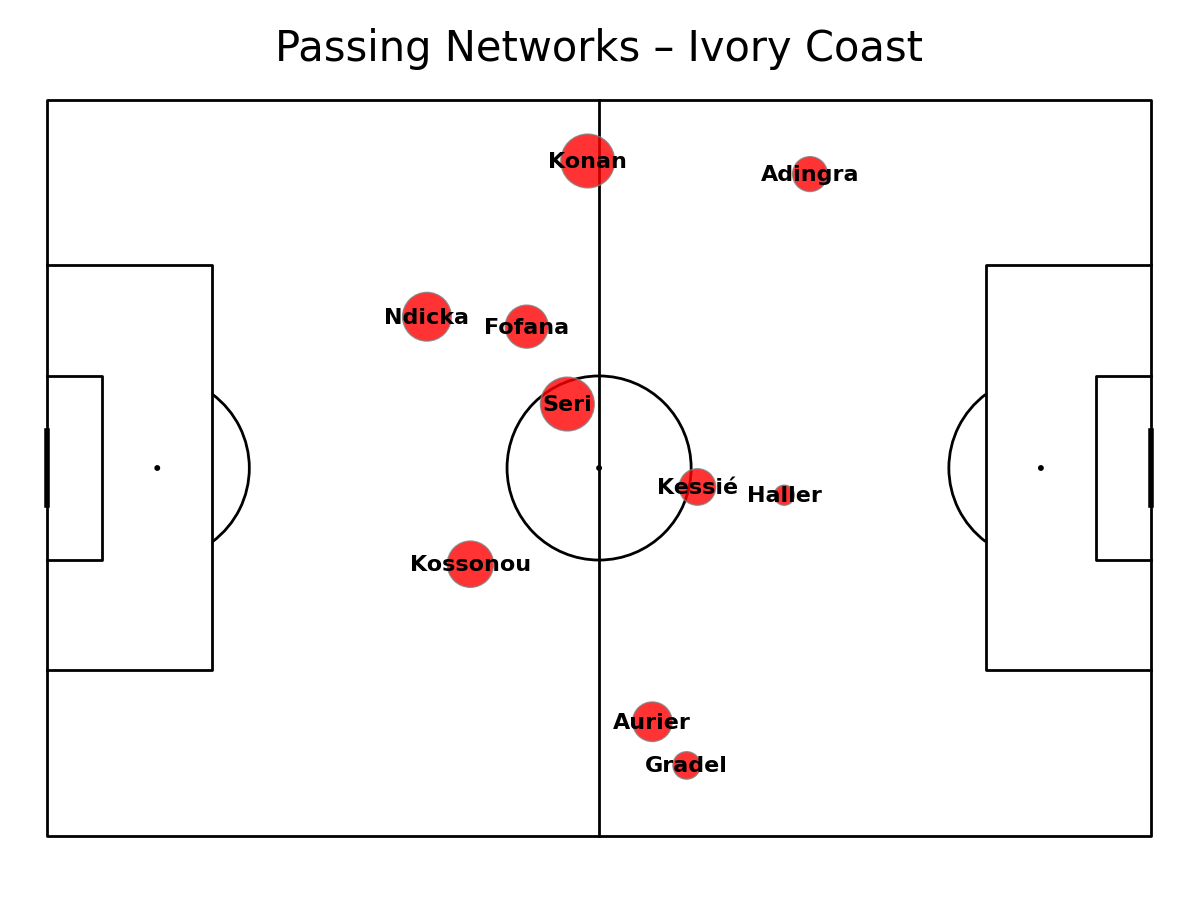

In [10]:
# Create the pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# Plot players
pitch.scatter(
    scatter_df.x,
    scatter_df.y,
    s=scatter_df.marker_size,
    color='red',
    edgecolors='grey',
    linewidth=1,
    alpha=0.8,
    ax=ax['pitch'],
    zorder=3
)

# Annotate player names
for i, row in scatter_df.iterrows():
    pitch.annotate(
        text=row.player_name,
        xy=(row.x, row.y),
        color='black',          
        verticalalignment='center', 
        horizontalalignment='center', 
        weight='bold',
        fontsize=16,           
        ax=ax['pitch'],
        zorder=4
    )

fig.suptitle("Passing Networks – Ivory Coast", fontsize=30)
plt.show()

### Lets explain a lil bit more this variables!

| Original Parameter | Complete Meaning      | Which is the meaning                                                             |
| ------------------ | --------------------- | -------------------------------------------------------------------------------  |
| `c`                | `color`               | Colour text.                        |
| `va`               | `verticalalignment`   | Align the text vertically (i.e: `'top'`, `'center'`, `'bottom'`).   |
| `ha`               | `horizontalalignment` | Align the text horizontally (i.e: `'left'`, `'center'`, `'right'`). |
| `size`             | `fontsize`            | Text size.                                                    |


### With this command, we finish designing the passing lines between players.


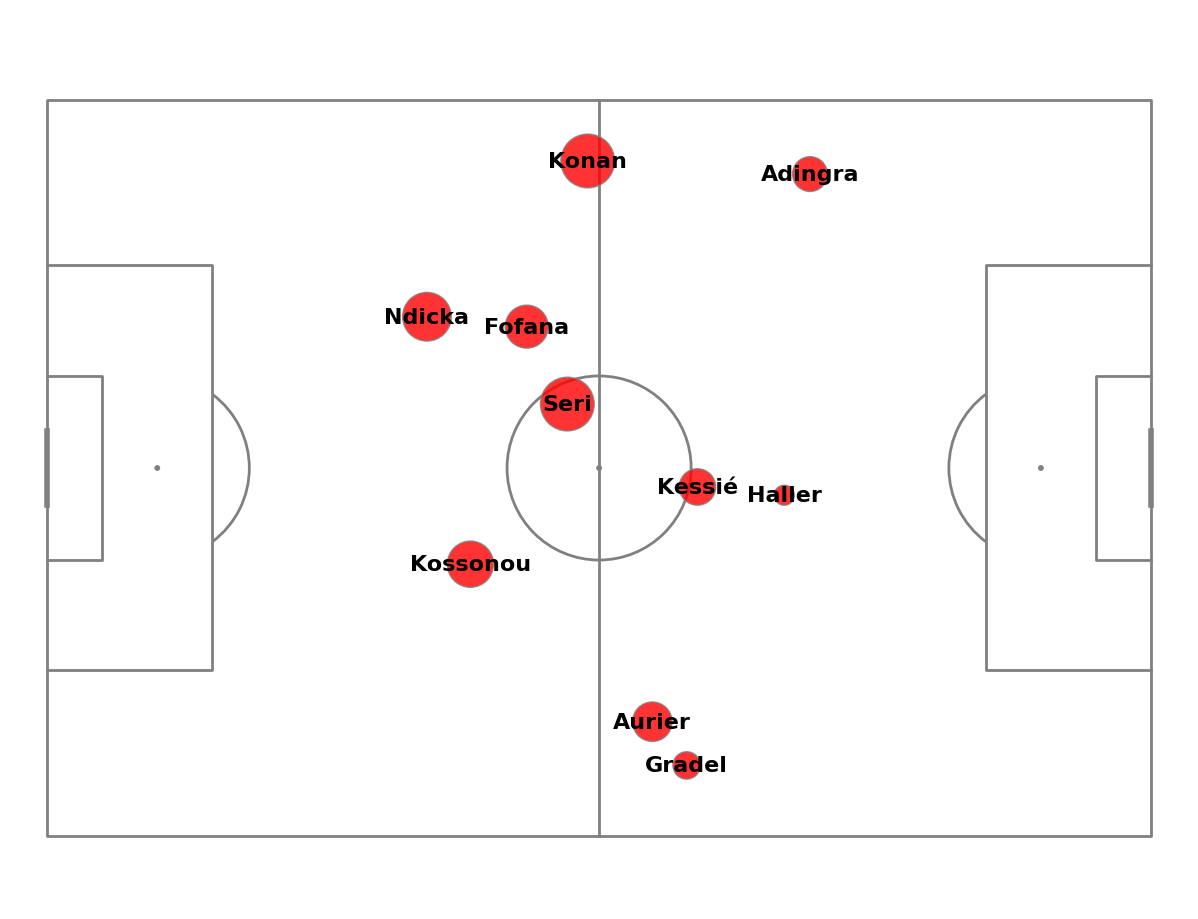

In [11]:
# Creating the Passing networks

pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, 
                     title_height=0.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

pitch.scatter(scatter_df.x, 
              scatter_df.y, 
              s=scatter_df.marker_size,
              color='red', 
              edgecolors='grey', 
              linewidth=1, 
              alpha=0.8, 
              ax=ax["pitch"],
              zorder=3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, 
                   xy=(row.x, row.y), 
                   c='black',
                   va='center', 
                   ha='center',
                   weight="bold", 
                   size=16, 
                   ax=ax['pitch'],
                   zorder=4)

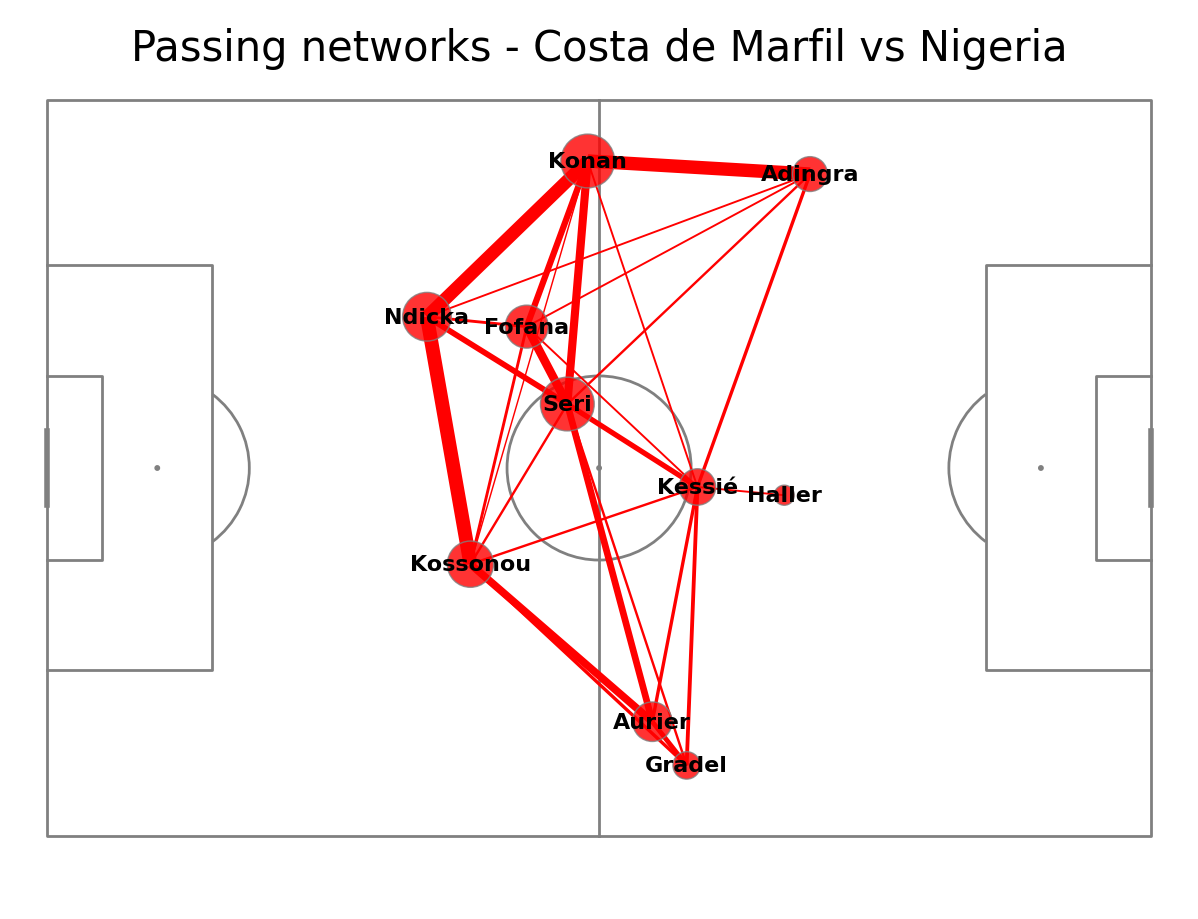

In [12]:
# Creating the Passing networks

pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, 
                     title_height=0.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

pitch.scatter(scatter_df.x, 
              scatter_df.y, 
              s=scatter_df.marker_size,
              color='red', 
              edgecolors='grey', 
              linewidth=1, 
              alpha=0.8, 
              ax=ax["pitch"],
              zorder=3)


for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, 
                   xy=(row.x, row.y), 
                   c='black',
                   va='center', 
                   ha='center',
                   weight="bold", 
                   size=16, 
                   ax=ax['pitch'],
                   zorder=4)

# Making the conections
for i,row in lines_df.iterrows():
    player_names = row["pair_key"].split()  # divide por espacio
    player1 = player_names[0]
    player2 = player_names[1]

    # We will search for the location and coordinates (X,Y) of each player
    player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]

    # The size of the line according to the amount of passes
    line_width = (num_passes / lines_df['pass_count'].max()) * 10

    pitch.lines(player1_x, 
                player1_y, 
                player2_x,
                player2_y,
                alpha=1, 
                lw=line_width, 
                zorder=2, 
                color="red", 
                ax=ax["pitch"])

fig.suptitle("Passing networks - Costa de Marfil vs Nigeria", fontsize=30)
plt.show()


### Which is the meaning of `loc`,`iloc`,`at`,`iat` ?

#### for example... if we have this data frame...

In [13]:
import pandas as pd

df = pd.DataFrame({
    "player": ["Fofana", "Adingra", "Kessié"],
    "passes": [20, 15, 25]
})

df

,player,passes
0,Fofana,20
1,Adingra,15
2,Kessié,25


| Método    | Qué usa                                | Ejemplo                            | Resultado                            |
| --------- | -------------------------------------- | ---------------------------------- | ------------------------------------ |
| `.loc[]`  | Etiquetas (nombres)                    | `df.loc[df["player"] == "Fofana"]` | Fila(s) donde `player` es `"Fofana"` |
| `.iloc[]` | Índices numéricos (posiciones)         | `df.iloc[0]`                       | Primera fila                         |
| `.at[]`   | Etiqueta única (rápido para una celda) | `df.at[0, "player"]`               | Valor “Fofana”                       |
| `.iat[]`  | Índice numérico único                  | `df.iat[0, 1]`                     | Valor 20                             |
